In [9]:
import mlflow
import mlflow.prophet
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import add_changepoints_to_plot
import optuna

from mlflow_prophet_lab.config import AppConfig, load_config
from mlflow_prophet_lab.data_loader import load_data, RateRecord
from mlflow_prophet_lab.holidays import get_holidays
from mlflow_prophet_lab.weekends_remover import remove_weekends

from matplotlib import pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

In [2]:
config: AppConfig = load_config()
mlflow.set_tracking_uri(config.db_uri)

loading config...
config loaded


In [3]:
records: list[RateRecord] = load_data(config)

In [4]:
df = pd.DataFrame([{"ds": r.date, "y": r.rate} for r in records])

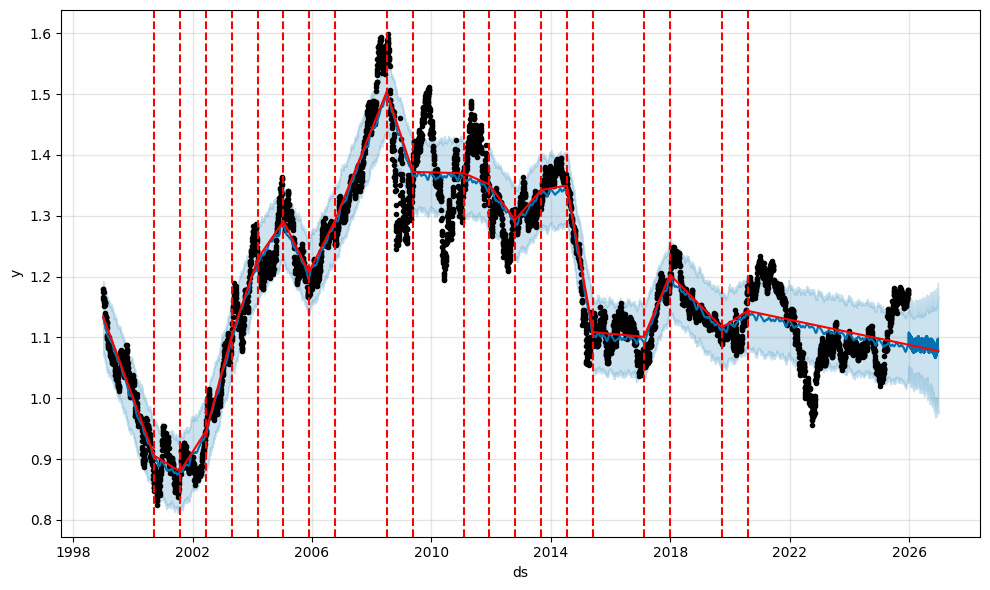

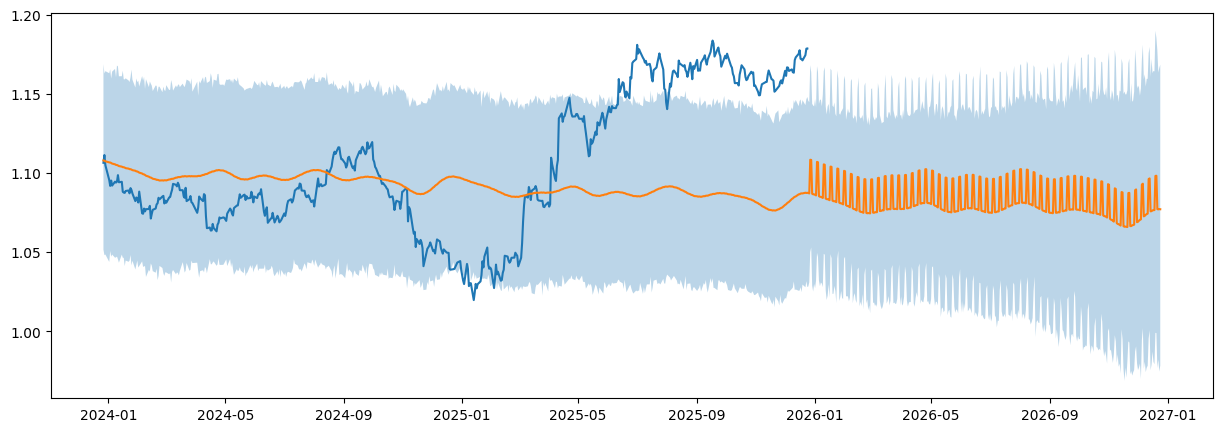

In [11]:
model_uri = "runs:/4fd6da0aed3a4ce39de3fb8f87e95016/prophet_model"
loaded_model = mlflow.prophet.load_model(model_uri)

future = loaded_model.make_future_dataframe(periods=365, include_history=True)
forecast = loaded_model.predict(future)

fig = loaded_model.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), loaded_model, forecast)

cutoff = forecast['ds'].max() - pd.DateOffset(years=3)
forecast = forecast[forecast['ds'] >= cutoff]
history = loaded_model.history[loaded_model.history['ds'] >= cutoff]

plt.figure(figsize=(15, 5))
plt.plot(history['ds'], history['y'], label="Actual")
plt.plot(forecast['ds'], forecast['yhat'], label="Forecast")
plt.fill_between(
    forecast['ds'],
    forecast['yhat_lower'],
    forecast['yhat_upper'],
    alpha=0.3
)

plt.show()

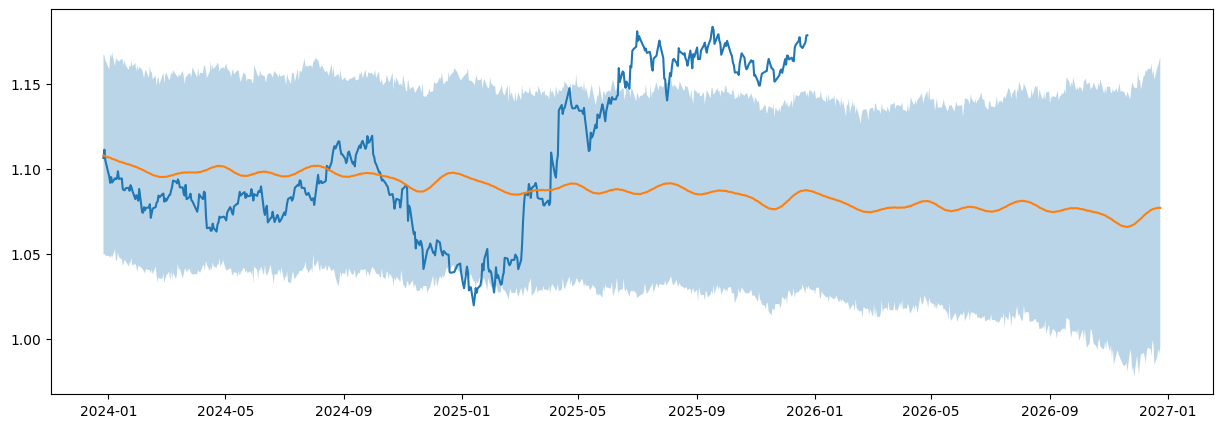

In [12]:
model_uri = "runs:/4fd6da0aed3a4ce39de3fb8f87e95016/prophet_model"
loaded_model = mlflow.prophet.load_model(model_uri)

future = loaded_model.make_future_dataframe(periods=365, include_history=True)
future = remove_weekends(future) # removing weekends cleans up jagged prediction
forecast = loaded_model.predict(future)

cutoff = forecast['ds'].max() - pd.DateOffset(years=3)
forecast = forecast[forecast['ds'] >= cutoff]
history = loaded_model.history[loaded_model.history['ds'] >= cutoff]

plt.figure(figsize=(15, 5))
plt.plot(history['ds'], history['y'], label="Actual")
plt.plot(forecast['ds'], forecast['yhat'], label="Forecast")
plt.fill_between(
    forecast['ds'],
    forecast['yhat_lower'],
    forecast['yhat_upper'],
    alpha=0.3
)

plt.show()

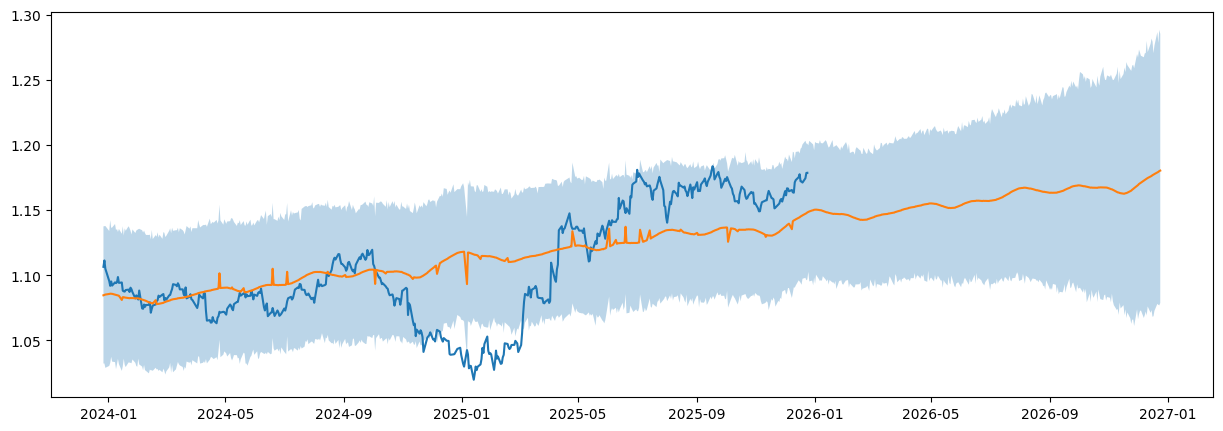

In [13]:
model_uri = "runs:/2e34902f1bb94bda9401364c2c025844/prophet_model"
loaded_model = mlflow.prophet.load_model(model_uri)

future = loaded_model.make_future_dataframe(periods=365, include_history=True)
future = remove_weekends(future) # removing weekends cleans up jagged prediction
forecast = loaded_model.predict(future)

cutoff = forecast['ds'].max() - pd.DateOffset(years=3)
forecast = forecast[forecast['ds'] >= cutoff]
history = loaded_model.history[loaded_model.history['ds'] >= cutoff]

plt.figure(figsize=(15, 5))
plt.plot(history['ds'], history['y'], label="Actual")
plt.plot(forecast['ds'], forecast['yhat'], label="Forecast")
plt.fill_between(
    forecast['ds'],
    forecast['yhat_lower'],
    forecast['yhat_upper'],
    alpha=0.3
)

plt.show()

In [6]:
pyfunc_model = mlflow.pyfunc.load_model(model_uri)

last_date = df.index.max()

future_dates = pd.date_range(
    start=last_date,
    periods=101,
    freq="D"
)

predictions = pyfunc_model.predict(pd.DataFrame({"ds": future_dates}))

In [7]:
predictions

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,1970-01-01 00:00:00.000006909,5.021271,4.961956,5.075856,5.021271,5.021271,-0.001575,-0.001575,-0.001575,-0.006051,-0.006051,-0.006051,0.004476,0.004476,0.004476,0.0,0.0,0.0,5.019696
1,1970-01-02 00:00:00.000006909,5.020904,4.959669,5.077777,5.020904,5.020904,-0.001936,-0.001936,-0.001936,-0.006220,-0.006220,-0.006220,0.004285,0.004285,0.004285,0.0,0.0,0.0,5.018968
2,1970-01-03 00:00:00.000006909,5.020537,4.984343,5.095871,5.020537,5.020537,0.019277,0.019277,0.019277,0.015190,0.015190,0.015190,0.004087,0.004087,0.004087,0.0,0.0,0.0,5.039814
3,1970-01-04 00:00:00.000006909,5.020170,4.984121,5.095053,5.020170,5.020170,0.019075,0.019075,0.019075,0.015190,0.015190,0.015190,0.003885,0.003885,0.003885,0.0,0.0,0.0,5.039245
4,1970-01-05 00:00:00.000006909,5.019803,4.959994,5.078455,5.019803,5.019803,-0.002301,-0.002301,-0.002301,-0.005984,-0.005984,-0.005984,0.003682,0.003682,0.003682,0.0,0.0,0.0,5.017502
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,1970-04-07 00:00:00.000006909,4.986054,4.918752,5.037761,4.986054,4.986054,-0.007377,-0.007377,-0.007377,-0.006142,-0.006142,-0.006142,-0.001235,-0.001235,-0.001235,0.0,0.0,0.0,4.978677
97,1970-04-08 00:00:00.000006909,4.985688,4.915873,5.031740,4.985688,4.985688,-0.007032,-0.007032,-0.007032,-0.005982,-0.005982,-0.005982,-0.001049,-0.001049,-0.001049,0.0,0.0,0.0,4.978656
98,1970-04-09 00:00:00.000006909,4.985321,4.917108,5.040890,4.985321,4.985321,-0.006895,-0.006895,-0.006895,-0.006051,-0.006051,-0.006051,-0.000844,-0.000844,-0.000844,0.0,0.0,0.0,4.978426
99,1970-04-10 00:00:00.000006909,4.984954,4.919262,5.034931,4.984954,4.984954,-0.006840,-0.006840,-0.006840,-0.006220,-0.006220,-0.006220,-0.000619,-0.000619,-0.000619,0.0,0.0,0.0,4.978114
